# import

In [1]:
import numpy as np
from scipy import stats #高度な科学技術計算を行うためのモジュール
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt 
from IPython.display import display, HTML # 画像表示などを行うためのモジュール
%matplotlib inline

# X-meansを行うクラスの定義

In [74]:
class XMeans:
    """
    x-means法を行うクラス
    """

    def __init__(self, k_init = 2, **k_means_args):
        """
        k_init : The initial number of clusters applied to KMeans()
        """
        self.k_init = k_init
        self.k_means_args = k_means_args

    def fit(self, X):
        """
        x-means法を使ってデータXをクラスタリングする
        X : array-like or sparse matrix, shape=(n_samples, n_features)
        """
        self.__clusters = [] #clustersにはもうこれ以上分割しないデータが格納される

        clusters = self.Cluster.build(X, KMeans(self.k_init, **self.k_means_args).fit(X))
        self.__recursively_split(clusters)

        self.labels_ = np.empty(X.shape[0], dtype = np.intp)
        for i, c in enumerate(self.__clusters):
            self.labels_[c.index] = i

        self.cluster_centers_ = np.array([c.center for c in self.__clusters])
        self.cluster_log_likelihoods_ = np.array([c.log_likelihood() for c in self.__clusters])
        self.cluster_sizes_ = np.array([c.size for c in self.__clusters])

        return self

    def __recursively_split(self, clusters):
        """
        引数のclustersを再帰的に分割する
        clusters : list-like object, which contains instances of 'XMeans.Cluster'
        'XMeans.Cluster'のインスタンスを含むリスト型オブジェクト
        """
        for cluster in clusters:
            if cluster.size <= 3:
                self.__clusters.append(cluster) #仮説：クラスタに含まれるデータの個数が3個以内の場合はこれ以上分割しない
                continue #cluster.size<=3だったら次のループへいく。そうではなかったら次の処理へ進む

            k_means = KMeans(2, **self.k_means_args).fit(cluster.data)
            c1, c2 = self.Cluster.build(cluster.data, k_means, cluster.index)

            beta = np.linalg.norm(c1.center - c2.center) / np.sqrt(np.linalg.det(c1.cov) + np.linalg.det(c2.cov))
            alpha = 0.5 / stats.norm.cdf(beta)
            bic = -2 * (cluster.size * np.log(alpha) + c1.log_likelihood() + c2.log_likelihood()) + 2 * cluster.df * np.log(cluster.size)
                      
            if bic < cluster.bic():
                self.__recursively_split([c1, c2]) #更なる分割を行う
            else:
                self.__clusters.append(cluster) #これ以上分割しない

    class Cluster:
        """
        k-means法によって生成されたクラスタに関する情報を持ち、尤度やBICの計算を行うクラス
        """

        @classmethod
        def build(cls, X, k_means, index = None): 
            if index is None:
                index = np.array(range(0, X.shape[0]))
            labels = range(0, k_means.get_params()["n_clusters"])  

            return tuple(cls(X, index, k_means, label) for label in labels) #ここでクラスター結果を入れたインスタンスを生成し、クラスタ数分の「インスタンスを返す
        

        # index: Xの各行におけるサンプルが元データの何行目のものかを示すベクトル
        def __init__(self, X, index, k_means, label):
            self.data = X[k_means.labels_ == label]
            self.index = index[k_means.labels_ == label]
            self.size = self.data.shape[0]
            self.df = self.data.shape[1] * (self.data.shape[1] + 3) / 2
            self.center = k_means.cluster_centers_[label]
            self.cov = np.cov(self.data.T)

        def log_likelihood(self):
            return sum(stats.multivariate_normal.logpdf(x, self.center, self.cov) for x in self.data)

        def bic(self):
            return -2 * self.log_likelihood() + self.df * np.log(self.size)

# X-meansを実行

## 重心が十分離れているパターン

No handles with labels found to put in legend.
findfont: Font family ['Hiragino Kaku Gothic Pro'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Hiragino Kaku Gothic Pro'] not found. Falling back to DejaVu Sans.


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3]
[[0.95908042 0.98500158]
 [2.03174532 1.01207745]
 [0.97942153 2.01812867]
 [1.9583946  2.04107479]]
[44.27132524 34.65116297 43.70440167 40.30251014]
[20 20 20 20]


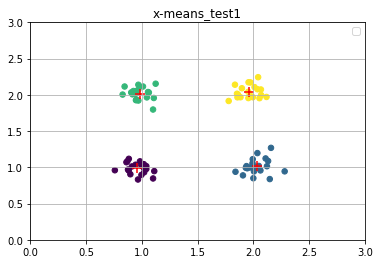

In [50]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    # データの準備
    x = np.array([np.random.normal(loc, 0.1, 20) for loc in np.repeat([1,2], 2)]).flatten() #ランダムな80個の数を生成
    y = np.array([np.random.normal(loc, 0.1, 20) for loc in np.tile([1,2], 2)]).flatten() #ランダムな80個の数を生成
        #np.repeat([1, 2], 2)の出力結果は1,1,2,2
        #np.tile([1, 2], 2)の出力結果は1,2,1,2
        #np.random.normal(平均, 標準偏差, 出力配列のサイズ)        
    
    # クラスタリングの実行
    x_means = XMeans(random_state = 1).fit(np.c_[x,y])  
    print(x_means.labels_)
    print(x_means.cluster_centers_)
    print(x_means.cluster_log_likelihoods_)
    print(x_means.cluster_sizes_)

    # 結果をプロット
    plt.rcParams["font.family"] = "Hiragino Kaku Gothic Pro"
    plt.scatter(x, y, c = x_means.labels_, s = 30)
    plt.scatter(x_means.cluster_centers_[:,0], x_means.cluster_centers_[:,1], c = "r", marker = "+", s = 100)
    plt.xlim(0, 3)
    plt.ylim(0, 3)
    plt.title("x-means_test1")
    plt.legend()
    plt.grid()
    plt.show()

## クラスタ数が多いパターン(クラスタ数=100)

No handles with labels found to put in legend.


[14 14 14 ...  9  9  9]
[[ 4.00214674  7.01219851]
 [ 3.98961636  8.00492535]
 [ 5.00098633  9.0123701 ]
 [ 4.99334028 10.00075047]
 [ 7.99656365  4.99820542]
 [ 8.00190431  5.99894528]
 [ 9.00331936  6.99754682]
 [ 8.99746587  7.99893054]
 [10.01277717  8.99350396]
 [ 9.99582     9.99849077]
 [ 5.99981994  0.99914102]
 [ 5.99749632  2.0131054 ]
 [ 7.00882925  2.99744271]
 [ 7.00281199  3.99863346]
 [ 0.99299344  1.00435474]
 [ 0.99690841  2.00936957]
 [ 1.99888809  2.9994271 ]
 [ 2.00475236  4.00117136]
 [ 2.98863515  4.99607886]
 [ 2.99856855  6.00442405]]
[351.14789104 356.99674248 342.86728932 357.17507784 362.14326379
 407.20211194 344.95152477 331.52646817 351.92349893 342.07416572
 358.76438896 364.40233902 361.34215047 359.21824804 362.85577409
 349.31339567 358.70597107 371.99490509 343.25929326 350.15311101]
[200 200 200 200 200 200 200 200 200 200 200 200 200 200 200 200 200 200
 200 200]


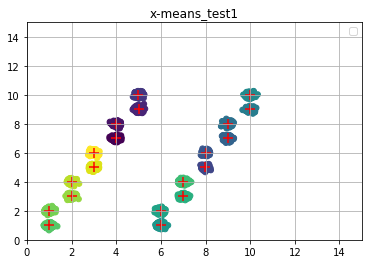

In [51]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    # データの準備
    x = np.array([np.random.normal(loc, 0.1, 200) for loc in np.repeat(range(1,11,1), 2)]).flatten() #ランダムな2000個の数を生成
    y = np.array([np.random.normal(loc, 0.1, 200) for loc in np.tile(range(1,11,1), 2)]).flatten() #ランダムな2000個の数を生成
        #np.repeat([1, 2], 2)の出力結果は1,1,2,2
        #np.tile([1, 2], 2)の出力結果は1,2,1,2
        #np.random.normal(平均, 標準偏差, 出力配列のサイズ)      
        #flattenは多次元配列を1次元に直すメソッド

        
    # クラスタリングの実行
    x_means = XMeans(random_state = 1).fit(np.c_[x,y])  
    print(x_means.labels_)
    print(x_means.cluster_centers_)
    print(x_means.cluster_log_likelihoods_)
    print(x_means.cluster_sizes_)

    # 結果をプロット
    plt.rcParams["font.family"] = "Hiragino Kaku Gothic Pro"
    plt.scatter(x, y, c = x_means.labels_, s = 30)
    plt.scatter(x_means.cluster_centers_[:,0], x_means.cluster_centers_[:,1], c = "r", marker = "+", s = 100)
    plt.xlim(0, 15)
    plt.ylim(0, 15)
    plt.title("x-means_test1")
    plt.legend()
    plt.grid()
    plt.show()

# クラスタが近いパターン

In [73]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    # データの準備
    x = np.array([np.random.normal(loc, 1, 500) for loc in np.repeat([1, 2], 2)]).flatten() #ランダムな2000個の数を生成
    y = np.array([np.random.normal(loc, 1, 500) for loc in np.tile([1, 2], 2)]).flatten() #ランダムな2000個の数を生成
        #np.repeat([1, 2], 2)の出力結果は1,1,2,2
        #np.tile([1, 2], 2)の出力結果は1,2,1,2
        #np.random.normal(平均, 標準偏差, 出力配列のサイズ)      
        #flattenは多次元配列を1次元に直すメソッド

        
    # クラスタリングの実行
    x_means = XMeans(random_state = 1).fit(np.c_[x,y])  
    print(x_means.labels_)
    print(x_means.cluster_centers_)
    print(x_means.cluster_log_likelihoods_)
    print(x_means.cluster_sizes_)

    # 結果をプロット
    plt.rcParams["font.family"] = "Hiragino Kaku Gothic Pro"
    plt.scatter(x, y, c = x_means.labels_, s = 30)
    plt.scatter(x_means.cluster_centers_[:,0], x_means.cluster_centers_[:,1], c = "r", marker = "+", s = 100)
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    plt.title("x-means_test1")
    plt.legend()
    plt.grid()
    plt.show()

LinAlgError: singular matrix

In [60]:
max(y)

4.955611625603801

# 説明変数が3次元の場合

In [35]:
# データの準備
x = np.array([np.random.normal(loc, 0.1, 20) for loc in np.repeat([1,2], 2)]).flatten() #ランダムな80個の数を生成
y = np.array([np.random.normal(loc, 0.1, 20) for loc in np.tile([1,2], 2)]).flatten() #ランダムな80個の数を生成
z = np.hstack([np.zeros(40).flatten(), np.array([np.random.normal(10, 1, 40)]).flatten()]) #ランダムな80個の数を生成
#np.repeat([1, 2], 2)の出力結果は1,1,2,2
#np.tile([1, 2], 2)の出力結果は1,2,1,2
#np.random.normal(平均, 標準偏差, 出力配列のサイズ)   
        
# クラスタリングの実行
x_means = XMeans(random_state = 1).fit(np.c_[x,y,z])  
print(x_means.labels_)
print(x_means.cluster_centers_)
print(x_means.cluster_log_likelihoods_)
print(x_means.cluster_sizes_)

<ipython-input-3-fab635a02940>:47: RuntimeWarning: divide by zero encountered in double_scalars
  beta = np.linalg.norm(c1.center - c2.center) / np.sqrt(np.linalg.det(c1.cov) + np.linalg.det(c2.cov))


LinAlgError: singular matrix

In [41]:
cov1 = np.cov(np.c_[x,y,z].T)
cov1

array([[ 2.54290606e-01, -8.57918101e-03,  2.53226146e+00],
       [-8.57918101e-03,  2.63698309e-01, -1.23298000e-01],
       [ 2.53226146e+00, -1.23298000e-01,  2.67344903e+01]])

In [48]:
testx=np.array([0,1])
testy=np.array([1,0])
np.linalg.norm(testx-testy)

1.4142135623730951